# Post-hoc Analysis

In [28]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd

import wandb
import json
from datetime import datetime

from dotenv import load_dotenv

load_dotenv(".env")

api = wandb.Api()
wandb.login()

from mediqa.all_metrics import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aryopg. Use `wandb login --relogin` to force relogin
/Users/aryopg/miniconda3/envs/mediqa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download predictions from WandB

In [2]:
# def save_artifact_to_csv(run_id, split, output_path):
#     artifact_name = f"aryopg/MEDIQA/run-{run_id}-{split}_prediction_df:v0"
#     artifact = api.artifact(artifact_name, type="run_table")  # You might need to adjust the type
#     artifact_dir = artifact.download()
    
#     with open(os.path.join(artifact_dir, f"{split}_prediction_df.table.json"), "r") as f:
#         data = json.load(f) 
#     df = pd.DataFrame(data["data"], columns=data["columns"])
    
#     df.to_csv(output_path, index=False)


# runs = api.runs("aryopg/MEDIQA")
# for idx, run in enumerate(runs):
#     if datetime.strptime(run.created_at, '%Y-%m-%dT%H:%M:%S') < pd.Timestamp("2024-03-26"):
#         print("================")

#         run_name = f"{run.group}__{run.name.lower()}".replace("-","_").replace(".", "")
#         print(idx, run_name)

#         os.makedirs(f"../predictions/{run_name}", exist_ok=True)

#         save_artifact_to_csv(run.id, "valid", f"../predictions/{run_name}/ms_prediction.csv")
#         save_artifact_to_csv(run.id, "test", f"../predictions/{run_name}/uw_prediction.csv")

## Performance of prompting strategies by metrics

In [3]:
ref_filepaths = {
    "ms": "../data/MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv",
    "uw": "../data/MEDIQA-CORR-2024-UW-ValidationSet-1-Full_Feb.csv"
}
predictions_dir = "../predictions"
columns = ["model", "Error Flags Accuracy", "Error Sentence Detection Accuracy", "aggregate_subset_check", "R1F_subset_check", "R2F_subset_check", "RLF_subset_check", "R1FC", "R2FC", "RLFC", "BERTSCORE_subset_check", "BERTC", "BLEURT_subset_check", "BLEURTC", "AggregateC"]

scores_dfs = {
    "ms": pd.DataFrame(columns=columns),
    "uw": pd.DataFrame(columns=columns),
}

for split in ["ms", "uw"]:
    if os.path.exists(f"{split}_eval.csv"):
        scores_dfs[split] = pd.read_csv(f"{split}_eval.csv")

In [7]:
def evaluate(split):
    reference_csv_file = ref_filepaths[split]

    nlg_metrics = NLGMetrics(
        metrics=["ROUGE", "BERTSCORE", "BLEURT"]
    )
    
    for prediction_dir in os.listdir(predictions_dir):
        if not os.path.isdir(os.path.join(predictions_dir, prediction_dir)): continue
        
        if prediction_dir in scores_dfs[split]["model"].values.tolist():
            print(f"{prediction_dir} has been evaluated. Skipped")
            continue
        
        print(f">>> {prediction_dir}")
        prediction_path = os.path.join(predictions_dir, prediction_dir, f"{split}_prediction.csv")

        reference_corrections, reference_flags, reference_sent_id = parse_reference_file(
            reference_csv_file
        )
        pred_df = pd.read_csv(prediction_path)
        candidate_corrections = {}
        candidate_flags = {}
        candidate_sent_id = {}
        for idx, error_flag, error_sentence_id, correction in pred_df[["id", "predicted_error_flag", "predicted_error_sentence_id", "predicted_corrected_sentence"]].values:
            candidate_flags[idx] = str(error_flag)
            candidate_sent_id[idx] = str(error_sentence_id)
            candidate_corrections[idx] = correction if pd.notna(correction) else "NA"

        # Accuracy
        accuracy_results = compute_accuracy(
            reference_flags, reference_sent_id, candidate_flags, candidate_sent_id
        )
        print("Accuracy Results:\n", accuracy_results)
        print()

        # NLG Eval for corrections
        references, predictions, counters = get_nlg_eval_data(
            reference_corrections, candidate_corrections
        )
        nlg_eval_results = nlg_metrics.compute(references, predictions, counters)
        print("NLG Eval Results:\n", nlg_eval_results)
        print()

        score_df = pd.DataFrame(
            {
                "model": [prediction_dir],
                "Error Flags Accuracy": accuracy_results["Error Flags Accuracy"],
                "Error Sentence Detection Accuracy": accuracy_results["Error Sentence Detection Accuracy"],
                "aggregate_subset_check": [nlg_eval_results["aggregate_subset_check"]],
                "R1F_subset_check": [nlg_eval_results["R1F_subset_check"]],
                "R2F_subset_check": [nlg_eval_results["R2F_subset_check"]],
                "RLF_subset_check": [nlg_eval_results["RLF_subset_check"]],
                "R1FC": [nlg_eval_results["R1FC"]],
                "R2FC": [nlg_eval_results["R2FC"]],
                "RLFC": [nlg_eval_results["RLFC"]],
                "BERTSCORE_subset_check": [nlg_eval_results["BERTSCORE_subset_check"]],
                "BERTC": [nlg_eval_results["BERTC"]],
                "BLEURT_subset_check": [nlg_eval_results["BLEURT_subset_check"]],
                "BLEURTC": [nlg_eval_results["BLEURTC"]],
                "AggregateC": [nlg_eval_results["AggregateC"]],
            }
        )
        
        scores_dfs[split] = pd.concat([scores_dfs[split], score_df], ignore_index=True)
        scores_dfs[split].to_csv(f"{split}_eval.csv", index=False)

In [8]:
evaluate("ms")

INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


>>> mcq_2opts__gpt_35_turbo
Accuracy Results:
 {'Error Flags Accuracy': 0.5574912891986062, 'Error Sentence Detection Accuracy': 0.5557491289198606}

calculating scores...
computing bert embedding.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.36s/it]


computing greedy matching.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 205.49it/s]


done in 18.93 seconds, 12.20 sentences/sec
NLG Eval Results:
 {'aggregate_subset_check': 0.5913131005522018, 'R1F_subset_check': 0.5333747409212246, 'R2F_subset_check': 0.40885625539760995, 'RLF_subset_check': 0.5311118687335404, 'R1FC': 0.36447659434286217, 'R2FC': 0.31436549651018797, 'RLFC': 0.3635659262673307, 'BERTSCORE_subset_check': 0.6520483853109987, 'BERTC': 0.4122355000119176, 'BLEURT_subset_check': 0.5885161754243817, 'BLEURTC': 0.38666765944779125, 'AggregateC': 0.38779325126752373}

cot_long_8_shot__gpt_35_turbo__bm25__hinted has been evaluated. Skipped
4_shot__gpt_35_turbo__bm25__hinted has been evaluated. Skipped
cot_soap_2_shot__gpt_35_turbo__random has been evaluated. Skipped
4_shot__gpt_35_turbo__random has been evaluated. Skipped
8_shot__gpt_35_turbo__random has been evaluated. Skipped
cot_long_8_shot__gpt_35_turbo__random__span_hinted has been evaluated. Skipped
4_shot__gpt_35_turbo__bm25 has been evaluated. Skipped
8_shot__gpt_35_turbo__bm25__hinted has been evalu

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:26<00:00,  3.32s/it]


computing greedy matching.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 164.77it/s]


done in 26.56 seconds, 9.60 sentences/sec
NLG Eval Results:
 {'aggregate_subset_check': 0.5826030873816784, 'R1F_subset_check': 0.512340410158274, 'R2F_subset_check': 0.3934358102970247, 'RLF_subset_check': 0.5110375604697542, 'R1FC': 0.3756912971957489, 'R2FC': 0.3228678251319535, 'RLFC': 0.3751125050867375, 'BERTSCORE_subset_check': 0.6552578260720361, 'BERTC': 0.43918248370796026, 'BLEURT_subset_check': 0.5802110259147252, 'BLEURTC': 0.40584287736629776, 'AggregateC': 0.406905552756669}

cot_long_4_shot__gpt_35_turbo__bm25 has been evaluated. Skipped
cot_soap_4_shot__gpt_35_turbo__bm25 has been evaluated. Skipped


In [9]:
evaluate("uw")

INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


>>> mcq_2opts__gpt_35_turbo
Accuracy Results:
 {'Error Flags Accuracy': 0.66875, 'Error Sentence Detection Accuracy': 0.65}

calculating scores...
computing bert embedding.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.67s/it]


computing greedy matching.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 177.30it/s]


done in 14.04 seconds, 5.13 sentences/sec
NLG Eval Results:
 {'aggregate_subset_check': 0.7070631266225915, 'R1F_subset_check': 0.6627407069936683, 'R2F_subset_check': 0.5395198457986454, 'RLF_subset_check': 0.6627407069936683, 'R1FC': 0.5232333181471507, 'R2FC': 0.46778393060939044, 'RLFC': 0.5232333181471507, 'BERTSCORE_subset_check': 0.7660983784331216, 'BERTC': 0.5697442702949047, 'BLEURT_subset_check': 0.6923502944409847, 'BLEURTC': 0.5365576324984431, 'AggregateC': 0.5431784069801662}

cot_long_8_shot__gpt_35_turbo__bm25__hinted has been evaluated. Skipped
4_shot__gpt_35_turbo__bm25__hinted has been evaluated. Skipped
cot_soap_2_shot__gpt_35_turbo__random has been evaluated. Skipped
4_shot__gpt_35_turbo__random has been evaluated. Skipped
8_shot__gpt_35_turbo__random has been evaluated. Skipped
cot_long_8_shot__gpt_35_turbo__random__span_hinted has been evaluated. Skipped
4_shot__gpt_35_turbo__bm25 has been evaluated. Skipped
8_shot__gpt_35_turbo__bm25__hinted has been evaluated.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.02s/it]


computing greedy matching.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 162.24it/s]


done in 15.07 seconds, 5.04 sentences/sec
NLG Eval Results:
 {'aggregate_subset_check': 0.7070144164866086, 'R1F_subset_check': 0.6626170723502828, 'R2F_subset_check': 0.5425409591618113, 'RLF_subset_check': 0.6611550840461892, 'R1FC': 0.4647431093663844, 'R2FC': 0.4077069556018603, 'RLFC': 0.4640486649219399, 'BERTSCORE_subset_check': 0.760740462298456, 'BERTC': 0.5113517195917666, 'BLEURT_subset_check': 0.6976857148110867, 'BLEURTC': 0.48140071453526617, 'AggregateC': 0.4858318478311391}

cot_long_4_shot__gpt_35_turbo__bm25 has been evaluated. Skipped
cot_soap_4_shot__gpt_35_turbo__bm25 has been evaluated. Skipped


## The performance of the model vs the position of the incorrect sentence

In [6]:
# import bert_score.score as bertscore
# import bleurt.score as bleurtscore
# import numpy as np
# from rouge import Rouge


# def sensitive_analysis_position(split):
#     reference_csv_file = ref_filepaths[split]
#     prediction_path = os.path.join(predictions_dir, "cot_brief_8_shot__gpt_35_turbo__random__span_hinted", f"{split}_prediction.csv")
    
#     reference_corrections, reference_flags, reference_sent_id = parse_reference_file(
#         reference_csv_file
#     )
#     pred_df = pd.read_csv(prediction_path)
#     candidate_corrections = {}
    # sentence_lengths = {}
#     for idx, correction in pred_df[["id", "predicted_corrected_sentence"]].values:
#         candidate_corrections[idx] = correction if pd.notna(correction) else "NA"
        # sentence_lengths[idx] = len(eval(split_sentences))
#
#     non_na_ids = [text_id for text_id, correction in reference_corrections.items() if correction != "NA" and candidate_corrections[text_id] != "NA"]
    # non_na_reference_sent_ids = [reference_sent_id[idx] for idx in non_na_ids]
    # sentence_lengths = [sentence_lengths[idx] for idx in non_na_ids]
    
#     # NLG Eval for corrections
#     references, predictions, counters = get_nlg_eval_data(
#         reference_corrections, candidate_corrections
#     )

#     rouge = Rouge()
#     rouge_scores = rouge.get_scores(predictions, references)
     
#     rouge1f_scores = []
#     for i in range(len(references)):
#         rouge1f_scores.append(rouge_scores[i]["rouge-1"]["f"])
     
#     bertScore_Precision, bertScore_Recall, bertScore_F1 = bertscore(
#         predictions,
#         references,
#         model_type="microsoft/deberta-xlarge-mnli",
#         lang="en",
#         device="cpu",
#         verbose=True,
#         rescale_with_baseline=True,
#     )  # roberta-large
     
#     bertscores = bertScore_F1.numpy()
#     ## clip scores to [0,1]
#     bertscores = np.array([clip(num) for num in bertscores])

#     bleurtscorer = bleurtscore.BleurtScorer(checkpoint="BLEURT-20")
     
#     bleurtscores = bleurtscorer.score(
#         references=references, candidates=predictions, batch_size=100
#     )
#     ## clip scores to [0,1]
#     bleurtscores = np.array([clip(num) for num in bleurtscores])

#     return non_na_reference_sent_ids, sentence_lengths, rouge1f_scores, bertscores, bleurtscores

In [7]:
# ms_non_na_reference_sent_ids, ms_sentence_lengths, ms_rouge1f_scores, ms_bertscores, ms_bleurtscores = sensitive_analysis_position("ms")

calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████| 8/8 [00:23<00:00,  2.92s/it]


computing greedy matching.


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 119.11it/s]


done in 23.43 seconds, 11.23 sentences/sec
INFO:tensorflow:Reading checkpoint BLEURT-20.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint BLEURT-20
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:BLEURT-20
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:... vocab_file:None
INFO:tensorflow:... do_lower_case:None
INFO:tensorflow:... sp_model:sent_piece
INFO:tensorflow:... dynamic_seq_length:True
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.
INFO:tensorflow:SentencePiece tokenizer created.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.


2024-04-05 17:23:31.134015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-05 17:23:31.139760: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [8]:
# uw_non_na_reference_sent_ids, uw_sentence_lengths, uw_rouge1f_scores, uw_bertscores, uw_bleurtscores = sensitive_analysis_position("uw")

calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████| 2/2 [00:12<00:00,  6.29s/it]


computing greedy matching.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 114.38it/s]

done in 12.60 seconds, 4.68 sentences/sec
INFO:tensorflow:Reading checkpoint BLEURT-20.



INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [48]:
ms_non_na_reference_sent_ids =  [5, 24, 4, 6, 12, 10, 13, 7, 11, 6, 0, 8, 7, 28, 7, 10, 3, 6, 4, 9, 9, 7, 5, 7, 5, 9, 16, 5, 3, 7, 0, 19, 9, 10, 10, 11, 10, 9, 15, 15, 12, 13, 11, 9, 7, 3, 13, 7, 14, 11, 12, 14, 8, 3, 8, 6, 9, 9, 11, 8, 12, 6, 4, 3, 9, 15, 16, 7, 34, 5, 5, 8, 16, 7, 22, 4, 11, 5, 5, 4, 10, 6, 5, 0, 6, 6, 5, 4, 16, 5, 12, 12, 2, 7, 13, 9, 8, 7, 8, 11, 6, 14, 13, 1, 6, 13, 10, 12, 8, 4, 7, 14, 5, 22, 4, 21, 26, 6, 32, 9, 20, 9, 15, 7, 14, 13, 7, 8, 8, 13, 8, 4, 9, 8, 16, 13, 17, 9, 2, 10, 10, 8, 15, 19, 12, 8, 20, 12, 10, 2, 8, 9, 14, 8, 20, 9, 12, 12, 13, 12, 8, 12, 5, 3, 12, 15, 9, 10, 10, 13, 11, 5, 13, 8, 29, 8, 15, 7, 14, 3, 7, 5, 3, 19, 10, 19, 11, 11, 9, 4, 15, 14, 9, 9, 15, 7, 9, 7, 12, 15, 6, 3, 6, 9, 8, 6, 6, 4, 6, 13, 14, 10, 9, 9, 2, 11, 5, 6, 9, 12, 5, 10, 32, 11, 7, 5, 3, 15, 3, 11, 7, 7, 7, 6, 4, 4, 7, 7, 5, 6, 10, 5, 6, 15, 10, 6, 6, 6, 6, 4, 6, 9, 8, 13, 11, 4, 5, 10, 5, 10, 16, 11, 7]
ms_non_na_reference_sent_ids = [sent_id + 1 for sent_id in ms_non_na_reference_sent_ids]
ms_sent_length = [10, 25, 5, 7, 14, 11, 14, 8, 12, 7, 11, 9, 9, 29, 13, 11, 21, 7, 5, 10, 36, 8, 7, 8, 6, 10, 18, 6, 9, 8, 24, 20, 11, 11, 13, 12, 14, 10, 17, 16, 15, 14, 14, 10, 8, 5, 14, 9, 15, 13, 13, 17, 9, 4, 9, 9, 14, 10, 12, 12, 13, 10, 5, 5, 10, 16, 17, 10, 35, 7, 6, 13, 17, 13, 23, 6, 12, 6, 6, 6, 11, 7, 6, 7, 7, 13, 6, 6, 17, 6, 16, 13, 4, 10, 16, 10, 13, 8, 11, 12, 15, 16, 14, 3, 7, 17, 11, 15, 9, 6, 12, 15, 7, 23, 10, 22, 27, 7, 33, 15, 21, 11, 16, 8, 15, 14, 8, 9, 11, 14, 9, 8, 10, 12, 17, 33, 18, 10, 3, 15, 11, 12, 16, 20, 13, 12, 21, 17, 11, 5, 14, 10, 18, 9, 21, 10, 18, 13, 18, 13, 9, 13, 6, 8, 13, 31, 10, 19, 11, 14, 12, 16, 14, 17, 30, 13, 16, 13, 15, 5, 10, 6, 6, 20, 11, 20, 13, 13, 10, 9, 16, 15, 10, 10, 16, 11, 10, 9, 14, 34, 7, 4, 10, 13, 9, 15, 7, 5, 7, 16, 15, 14, 10, 17, 3, 13, 6, 7, 12, 33, 6, 12, 33, 14, 10, 7, 5, 16, 13, 12, 15, 8, 12, 7, 9, 5, 9, 8, 6, 9, 11, 6, 9, 16, 13, 8, 7, 10, 7, 6, 7, 10, 15, 14, 31, 5, 6, 11, 8, 11, 17, 12, 10]
ms_rouge1f_scores =  [0.999999995, 0.624999995, 0.8888888839506174, 0.999999995, 0.5714285665306124, 0.999999995, 0.999999995, 0.999999995, 0.8666666616666667, 0.8333333283333335, 0.8888888838913581, 0.999999995, 0.5263157851523547, 0.8749999950781251, 0.999999995, 0.4999999950000001, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.6153846104142012, 0.5714285665306124, 0.9411764655901577, 0.4999999950000001, 0.5999999950000001, 0.7142857092857143, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.7272727223140496, 0.10526315357340738, 0.999999995, 0.7999999950222222, 0.999999995, 0.999999995, 0.33333332888888895, 0.8749999950781251, 0.4444444395061729, 0.4444444395061729, 0.7857142807142857, 0.999999995, 0.5217391258979208, 0.999999995, 0.8181818131818183, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.4444444395061729, 0.6666666616888889, 0.999999995, 0.999999995, 0.9285714235714286, 0.8571428522448981, 0.41666666291666676, 0.999999995, 0.999999995, 0.3076923029585799, 0.7499999950347224, 0.7999999950222222, 0.999999995, 0.999999995, 0.999999995, 0.5714285665306124, 0.4444444395061729, 0.9090909041322315, 0.999999995, 0.499999995138889, 0.7199999950079999, 0.7999999950222222, 0.4444444395061729, 0.4444444395061729, 0.4347826052930058, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.9090909041322315, 0.9285714235714286, 0.999999995, 0.999999995, 0.9090909041322315, 0.999999995, 0.999999995, 0.999999995, 0.8571428521428571, 0.7058823480103807, 0.09999999580000019, 0.0, 0.14285713826530627, 0.4285714235714286, 0.39999999505, 0.999999995, 0.33333332888888895, 0.6153846104142012, 0.8888888838957477, 0.5833333284722223, 0.6249999953125001, 0.0, 0.49999999531250006, 0.999999995, 0.999999995, 0.7999999950080001, 0.999999995, 0.9230769181065088, 0.2666666630888889, 0.6274509754402153, 0.999999995, 0.4615384572781066, 0.18181817685950424, 0.2857142808163266, 0.2499999955555556, 0.7999999952000001, 0.9090909041322315, 0.8372092973282856, 0.7499999950347224, 0.24999999531250006, 0.999999995, 0.22222221777777784, 0.999999995, 0.2857142808163266, 0.0, 0.7719298195629424, 0.999999995, 0.9090909040909091, 0.0, 0.11764705397923896, 0.999999995, 0.13333332942222234, 0.6666666618666668, 0.999999995, 0.7058823479584776, 0.6666666616888889, 0.999999995, 0.7741935433922998, 0.39999999500800004, 0.8181818131818183, 0.44444444000000005, 0.4615384568047337, 0.999999995, 0.14285713877551035, 0.4444444395061729, 0.18181817719008275, 0.999999995, 0.5263157845983379, 0.3076923027218935, 0.999999995, 0.888888883888889, 0.0, 0.6086956474102081, 0.6666666616666668, 0.18181817785123974, 0.3076923027218935, 0.8888888838957477, 0.999999995, 0.6896551674673009, 0.79999999505, 0.967741930489074, 0.6666666616888889, 0.09999999625000015, 0.999999995, 0.4285714236734694, 0.39999999520000007, 0.33333332839506175, 0.0, 0.5714285664285715, 0.16666666291666676, 0.999999995, 0.24999999500000009, 0.2857142816326531, 0.11764705384083066, 0.6666666618666668, 0.3076923029585799, 0.4999999950000001, 0.4285714236734694, 0.8333333283333335, 0.11764705467128042, 0.5142857093877552, 0.0, 0.749999995, 0.5454545404958678, 0.16666666222222234, 0.45454544954545456, 0.7499999950347224, 0.6249999953125001, 0.10526315357340738, 0.4444444395061729, 0.4444444395061729, 0.0833333295833335, 0.6249999950781252, 0.999999995, 0.5454545408264463, 0.22222221728395072, 0.6666666617687076, 0.9166666616666667, 0.4615384568047337, 0.5999999952, 0.7999999950000002, 0.7272727222727273, 0.5454545404958678, 0.999999995, 0.7692307642603551, 0.5714285664540818, 0.8571428521428571, 0.999999995, 0.8571428521541952, 0.5217391254442345, 0.749999995, 0.8571428521541952, 0.999999995, 0.967741930489074, 0.8275862019024971, 0.7368421002770082, 0.7368421003185596, 0.8974358924391849, 0.4999999950000001, 0.0, 0.18181817719008275, 0.2857142808163266, 0.4999999950000001, 0.13333332835555575, 0.6666666616666668, 0.0, 0.999999995, 0.36363635900826446, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.7999999950000002, 0.6666666616666668, 0.24999999500000009, 0.999999995, 0.999999995, 0.9285714235714286, 0.999999995, 0.874999995, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.999999995, 0.2222222182098766, 0.38461538035502957, 0.09523809115646274, 0.2105263111357342, 0.6666666616666668, 0.999999995, 0.999999995, 0.9166666616666667, 0.15384614958579892, 0.8387096724245579, 0.7999999950222222, 0.7272727223140496, 0.6451612855775234, 0.84999999505, 0.3999999958, 0.9047618997619049, 0.23076922816568046, 0.18181817685950424]
ms_bertscores=[1.,0.7504133,0.88707018,1.,0.72943842,0.99999976,1.,1.,0.85256815,0.85475111,0.871126,1.,0.59828728,0.77133584,1.,0.59972155,1.,0.92732507,1.,1.,0.99999988,1.,0.77814406,0.45086735,0.94421607,0.73958474,0.80614561,0.89246947,1.,1.,1.,0.99999988,0.70622683,0.30752346,1.,0.86768121,1.,1.,0.46423751,0.7576164,0.5888626,0.80966979,0.67674327,1.,0.47207135,0.99999964,0.81156665,1.,1.,0.99999988,0.99999988,0.61810374,0.68924057,1.,1.,0.90494919,0.34326112,0.55046868,1.,1.,0.6840077,0.86421758,0.71311361,1.,1.,1.,0.8010869,0.60389316,0.93910599,0.99999976,0.65454853,0.79111642,0.7577039,0.80904853,0.7590223,0.3989875,0.99999976,1.,1.,1.,1.,0.96746725,1.,0.99999988,0.95355743,1.,1.,1.,0.95346218,0.64620173,0.11332852,0.1195564,0.38316709,0.62981862,0.45648074,1.,0.40844807,0.62527668,0.9175576,0.49667454,0.46797875,0.49777892,0.63156325,1.,1.,0.84983939,0.99999976,0.87973827,0.22942194,0.4169538,1.,0.72010064,0.253279,0.62668145,0.49802977,0.59822446,1.,0.72505254,0.79434723,0.46746907,1.,0.25402415,1.,0.49009171,0.13356467,0.81073791,1.,0.98477799,0.20718436,0.22897729,1.,0.15194771,0.59640861,1.,0.6158551,0.71122974,1.,0.78546667,0.62461025,0.91370243,0.36851224,0.41535386,0.99999988,0.26596731,0.43835592,0.24384941,1.,0.65219915,0.51604927,0.99999988,0.93441719,0.27281216,0.57702267,0.69217962,0.37145966,0.54305285,0.91343135,0.99999988,0.68406975,0.73110694,0.87286085,0.71955287,0.177848,0.99999988,0.72399908,0.5750522,0.37643296,0.23274605,0.46268061,0.14522244,1.,0.47041047,0.38381982,0.25027013,0.63846707,0.30702558,0.64088011,0.49763095,0.9315778,0.25304598,0.5841502,0.37310886,0.91410029,0.72320843,0.36125383,0.58633995,0.82475948,0.6202057,0.13874212,0.50895494,0.51014698,0.16611709,0.6555717,1.,0.39130729,0.32281148,0.54206568,0.88490665,0.6000644,0.53555673,0.92341584,0.68358845,0.58608603,1.,0.81380987,0.53452045,0.83637595,1.,0.94239801,0.47218984,0.79342276,0.69715625,1.,0.99999988,0.91384184,0.78225231,0.60066801,0.9489854,0.60838509,0.16192862,0.48417526,0.66704547,0.39489183,0.43399611,0.77360326,0.52420324,1.,0.5779314,1.,1.,1.,1.,0.86593193,0.72747028,0.43838036,0.99999976,1.,0.89692253,1.,0.90990627,0.99999988,1.,1.,1.,1.,0.3048957,0.46121353,0.14458434,0.39819467,0.76596016,1.,1.,0.89152175,0.23326604,0.8290379,0.89107907,0.70676869,0.72942978,0.63409412,0.41028017,0.26123661,0.31598201,0.5746358,]
ms_bleurtscores=[0.96624076,0.64717406,0.92854041,0.97892666,0.437262,1.,0.99923742,0.99945122,0.74816877,0.73481613,0.76477885,0.9570111,0.50820851,0.71214634,0.9695043,0.4305042,0.97827142,0.95492482,0.96234363,0.95571035,0.96226639,0.9807502,0.64855212,0.43152702,0.87060803,0.78130829,0.50026959,0.76743656,0.95959932,0.96712911,0.98115081,0.97750157,0.55196577,0.23897803,0.96795112,0.80462831,0.97513634,0.95388544,0.33565396,0.74226755,0.46991593,0.47347951,0.65462989,0.96926284,0.30816409,0.95027572,0.6460458,0.96578425,0.98292691,0.95920414,0.99348593,0.50435865,0.50374925,0.98290056,0.96319872,0.80384296,0.68869424,0.38240758,0.9886871,0.97733438,0.53133774,0.6126042,0.83474147,0.99361575,0.96533716,0.97883278,0.53670317,0.41135705,0.78771663,0.97799867,0.56136823,0.54988229,0.57992446,0.52820235,0.48613912,0.59888953,0.983805,1.,0.96159154,0.94706631,0.97216147,0.89885688,0.97701234,0.98335308,0.74294102,0.97720951,0.96366113,0.98505002,0.79927188,0.6185869,0.25082678,0.45312315,0.32301518,0.54407823,0.34909099,1.,0.48781502,0.52616978,0.79388636,0.57597119,0.58161157,0.34266144,0.41000938,0.97888297,0.9813059,0.60865688,0.96979457,0.80968243,0.38438123,0.47548437,0.99387604,0.5783698,0.45254457,0.71608347,0.51616722,0.71939278,0.951855,0.67418844,0.70177847,0.37601984,0.97613001,0.27728575,0.98472399,0.24936409,0.22772068,0.67887712,0.95645875,0.88287336,0.34753805,0.34584516,0.97855747,0.28639895,0.575629,0.99102134,0.52275485,0.52831692,0.96452093,0.65960801,0.70691866,0.75991976,0.29934072,0.47154516,0.95808727,0.28811419,0.47069168,0.27392507,1.,0.60164928,0.3815549,0.99625498,0.83529514,0.63019836,0.47513103,0.6031335,0.28737897,0.4567824,0.84407628,0.97321039,0.56470066,0.71993637,0.87853569,0.66630149,0.29685467,0.99390167,0.42976004,0.40992492,0.47096074,0.29844993,0.55675924,0.33268416,1.,0.31850123,0.51607007,0.27545434,0.67334563,0.42385793,0.37093496,0.57013375,0.93161458,0.26761815,0.53152847,0.37607309,0.60300124,0.44800127,0.35042772,0.57718033,0.69499415,0.38666123,0.31906378,0.46715653,0.46643162,0.22287346,0.66954732,0.98615056,0.36667567,0.24403849,0.70928758,0.74912411,0.54998827,0.51906216,0.75766015,0.57988811,0.36029813,0.97181851,0.61406088,0.62952745,0.70899403,0.95547897,0.87394601,0.48631132,0.67924577,0.49166512,0.96873832,0.94863331,0.82042515,0.65887028,0.44715536,0.82483071,0.54302013,0.21812731,0.46185267,0.6754899,0.49049574,0.40918452,0.6287173,0.3600955,0.99098533,0.50220543,0.98721987,0.97937816,1.,0.96643478,0.79274815,0.56217587,0.29513681,1.,0.97800142,0.70248073,1.,0.77741569,1.,0.96592396,0.98419768,0.97859693,0.98848724,0.40367794,0.49344379,0.33191174,0.45743978,0.55197978,0.9903267,0.95150512,0.79930133,0.38710648,0.80460113,0.65644127,0.69747764,0.64304465,0.74034649,0.37397218,0.60746229,0.35422409,0.50856888]


uw_non_na_reference_sent_ids = [0, 0, 0, 3, 0, 2, 4, 0, 4, 0, 0, 3, 2, 3, 1, 3, 3, 2, 0, 3, 0, 3, 1, 3, 0, 8, 0, 4, 3, 4, 1, 5, 1, 1, 2, 2, 4, 2, 8, 0, 0, 1, 0, 1, 2, 2, 3, 1, 4, 2, 0, 6, 2, 1, 6, 4, 0, 7, 0]
uw_non_na_reference_sent_ids = [sent_id + 1 for sent_id in uw_non_na_reference_sent_ids]
uw_sent_length = [3, 3, 12, 6, 5, 3, 6, 9, 6, 6, 8, 4, 3, 4, 4, 6, 7, 4, 4, 7, 7, 5, 5, 8, 5, 10, 6, 5, 4, 7, 5, 7, 3, 4, 5, 4, 12, 6, 9, 11, 4, 11, 4, 3, 3, 4, 5, 3, 12, 4, 4, 10, 4, 3, 9, 6, 3, 17, 6]
uw_rouge1f_scores = [0.888888883888889, 0.9523809473922903, 0.9230769180769233, 0.968749995, 0.8679245233179067, 0.9285714235714286, 0.4999999950000001, 0.9666666616666667, 0.9599999950000001, 0.999999995, 0.9032258014568159, 0.9499999950000001, 0.6666666619501135, 0.0, 0.9230769181065088, 0.8620689605231867, 0.8444444394469136, 0.999999995, 0.8571428521428571, 0.9285714235714286, 0.999999995, 0.3076923034319527, 0.899999995, 0.9729729679766254, 0.999999995, 0.6153846104142012, 0.8666666616666667, 0.1111111083333334, 0.8965517191438764, 0.888888883888889, 0.999999995, 0.9230769180769233, 0.9523809473822121, 0.9743589693622617, 0.05405405010956932, 0.9583333283333335, 0.9230769180769233, 0.7142857093112245, 0.8666666616666667, 0.5454545404958678, 0.9361702077682209, 0.9090909040955004, 0.999999995, 0.9499999950000001, 0.8421052581717452, 0.5714285664285715, 0.7368421002770082, 0.5454545411157026, 0.874999995, 0.9230769180769233, 0.888888883888889, 0.39999999520000007, 0.8936170162788593, 0.899999995, 0.999999995, 0.9090909040909091, 0.9824561353524162, 0.5999999956722223, 0.9411764655925606]
uw_bertscores = [0.5720039,0.88376892,0.8668946,0.98434204,0.91506582,0.91225725,0.39810643,0.926494,0.94229931,1.,0.87717503,0.99015045,0.55923176,0.02136217,0.69488698,0.86602581,0.79979104,0.89227247,0.71597606,0.93333173,1.,0.63878536,0.99061173,0.93776178,0.99999988,0.58504075,0.91790015,0.08240367,0.92271245,0.99059868,1.,0.91644019,0.95111966,0.81299746,0.,0.9442687,0.86263502,0.71119744,0.87785912,0.65772015,0.89569944,0.87537122,0.9767707,0.92165881,0.8301546,0.55337667,0.62328643,0.55133724,0.91112041,0.82997257,0.90183586,0.79011601,0.92220122,0.81041127,1.,0.7963714,0.93853372,0.56604517,0.96414876]
uw_bleurtscores = [0.89141911,0.76442713,0.71262765,0.89667195,0.77843267,0.7590695,0.43052614,0.76511306,0.99179798,0.95473409,0.76781231,0.93495363,0.61753809,0.26191586,0.51477396,0.66044253,0.59065777,0.860416,0.53893065,0.94835538,0.9499858,0.69262409,0.89970791,0.88605732,0.95319551,0.56481701,0.72943163,0.22073187,0.86177552,0.89680815,1.,0.78736109,0.9346143,0.84787768,0.19220293,0.87139529,0.71631348,0.6421625,0.66943699,0.47878754,0.77789891,0.60056388,0.99160099,0.82042402,0.80767679,0.66001785,0.5483287,0.28287649,0.83595502,0.68487471,0.73841,0.61891943,0.69009602,0.72222352,1.,0.77570593,0.85762089,0.46803695,0.84757793]

In [50]:
# bucketise ms_non_na_reference_sent_ids and uw_non_na_reference_sent_ids wrt their respective sentence lengths into 3 buckets, beginning, middle, end
def bucketise_id(sent_ids, sent_lengths):
    bucketised_sent_ids = []
    for sent_id, sent_length in zip(sent_ids, sent_lengths):
        if sent_id == 1:
            bucketised_sent_ids += ["beginning"]
        elif sent_id == sent_length:
            bucketised_sent_ids += ["end"]
        else:
            bucketised_sent_ids += ["middle"]

    return bucketised_sent_ids

In [84]:
# bucketise ms_non_na_reference_sent_ids and uw_non_na_reference_sent_ids wrt their respective sentence lengths into 5 buckets depending on the sentence length
def fifth_bucketise_id(sent_ids, sent_lengths):
    bucketised_sent_ids = []
    for sent_id, sent_length in zip(sent_ids, sent_lengths):
        if sent_id <= sent_length * 0.2:
            bucketised_sent_ids += ["1"]
        elif sent_id <= sent_length * 0.4:
            bucketised_sent_ids += ["2"]
        elif sent_id <= sent_length * 0.6:
            bucketised_sent_ids += ["3"]
        elif sent_id <= sent_length * 0.8:
            bucketised_sent_ids += ["4"]
        else:
            bucketised_sent_ids += ["5"]
    return bucketised_sent_ids

In [51]:
ms_bucketised_sent_ids = bucketise_id(ms_non_na_reference_sent_ids, ms_sent_length)
uw_bucketised_sent_ids = bucketise_id(uw_non_na_reference_sent_ids, uw_sent_length)

In [85]:
ms_fifth_bucketised_sent_ids = fifth_bucketise_id(ms_non_na_reference_sent_ids, ms_sent_length)
uw_fifth_bucketised_sent_ids = fifth_bucketise_id(uw_non_na_reference_sent_ids, uw_sent_length)

In [82]:
ms_data["Sentence Position"].value_counts()

Sentence Position
end          456
middle       324
beginning      9
Name: count, dtype: int64

In [83]:
uw_data["Sentence Position"].value_counts()

Sentence Position
middle       102
beginning     51
end           24
Name: count, dtype: int64

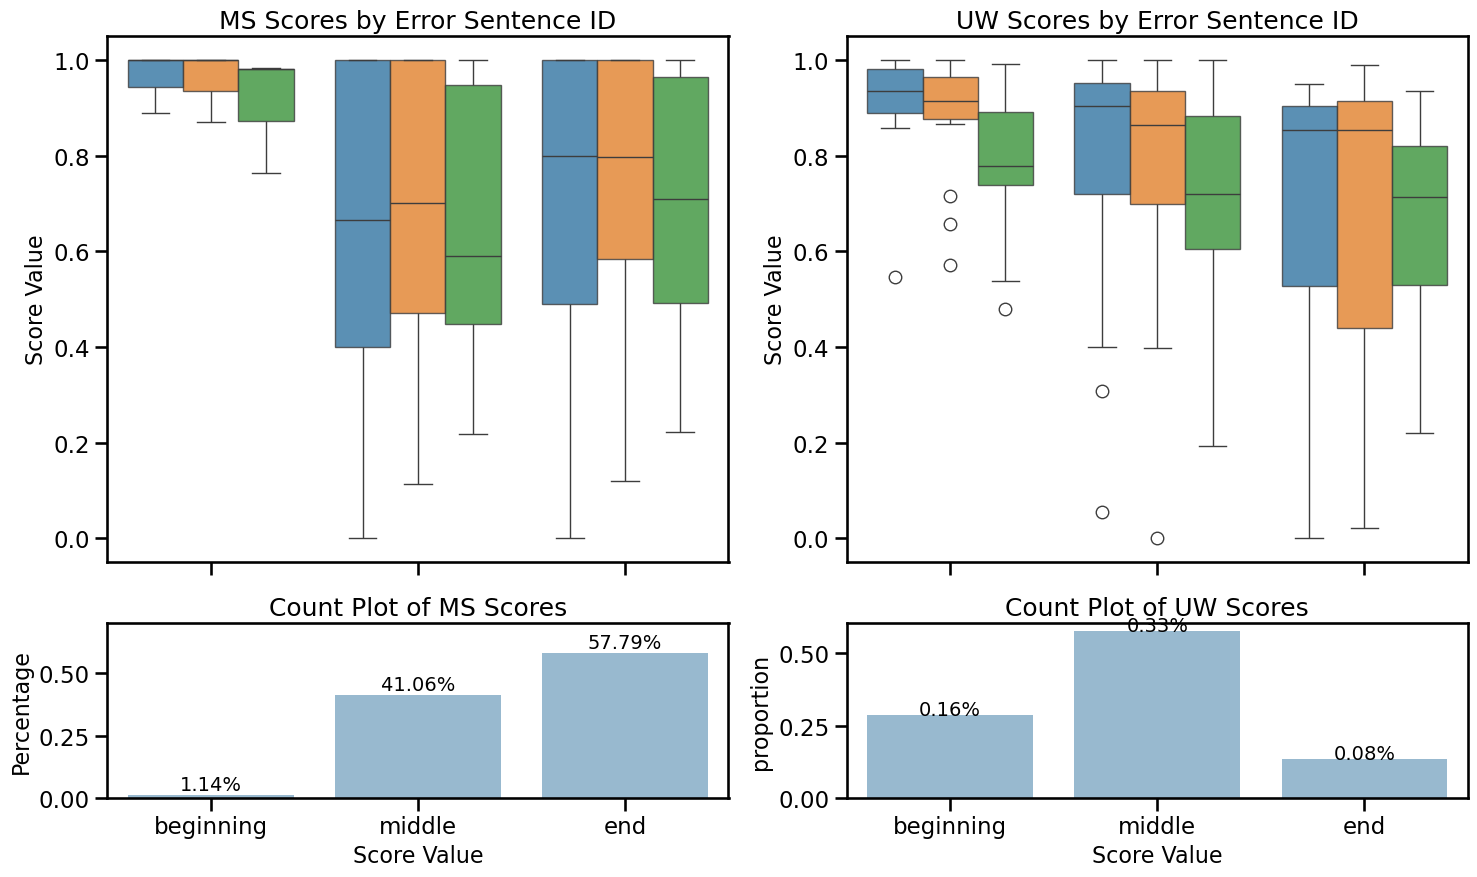

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine MS data into a DataFrame
ms_data = pd.DataFrame({
    'Score Value': ms_rouge1f_scores + ms_bertscores + ms_bleurtscores,
    'Score Type': ['Rouge1f'] * len(ms_rouge1f_scores) + ['BERTScores'] * len(ms_bertscores) + ['BLEURT'] * len(ms_bleurtscores),
    'Sentence Position': ms_bucketised_sent_ids + ms_bucketised_sent_ids + ms_bucketised_sent_ids,
    'Sentence Position (20%)': ms_fifth_bucketised_sent_ids + ms_fifth_bucketised_sent_ids + ms_fifth_bucketised_sent_ids
})

# Combine UW data into a DataFrame
uw_data = pd.DataFrame({
    'Score Value': uw_rouge1f_scores + uw_bertscores + uw_bleurtscores,
    'Score Type': ['Rouge1f'] * len(uw_rouge1f_scores) + ['BERTScores'] * len(uw_bertscores) + ['BLEURT'] * len(uw_bleurtscores),
    'Sentence Position': uw_bucketised_sent_ids + uw_bucketised_sent_ids + uw_bucketised_sent_ids,
})

# Define the order of the x-axis categories and hue order
order = ["beginning", "middle", "end"]
hue_order = ['Rouge1f', 'BERTScores', 'BLEURT']
custom_palette = {'Rouge1f': '#4BA1BF', 'BERTScores': '#bf4ba1', 'BLEURT': '#a1bf4b'}

plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'legend.fontsize': 14})
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex='col', gridspec_kw={'height_ratios': [3, 1]})
ax = axes.flatten()

# Plot combined boxplot for MS
# MS boxplot
sns.boxplot(x='Sentence Position', y='Score Value', hue='Score Type', data=ms_data, ax=ax[0], order=order, hue_order=hue_order, boxprops=dict(alpha=.8))
ax[0].set_title("MS Scores by Error Sentence ID")
ax[0].get_legend().remove()

# MS count plot
value_counts_df = ms_data["Sentence Position"].value_counts(normalize=True).reset_index()
value_counts_df.columns = ['Category', 'Percentage']
# Create a bar plot from the value counts
sns.barplot(x='Category', y='Percentage', data=value_counts_df, ax=ax[2], fill=True, alpha=0.5)
for p in ax[2].patches:
    height = p.get_height()  # Get the height of each bar
    ax[2].text(p.get_x()+p.get_width()/2., height+0.02, '{:1.2f}%'.format(100 * height), ha="center") 
ax[2].set_xlabel('Score Value')
ax[2].set_ylim(0,0.7)
ax[2].set_title('Count Plot of MS Scores')

# UW boxplot
sns.boxplot(x='Sentence Position', y='Score Value', hue='Score Type', data=uw_data, ax=ax[1], order=order, hue_order=hue_order, boxprops=dict(alpha=.8))
ax[1].set_title("UW Scores by Error Sentence ID")
ax[1].get_legend().remove()

# UW count plot
value_counts_df = uw_data["Sentence Position"].value_counts(normalize=True).reset_index()
value_counts_df.columns = ['Category', 'Percentage']
# Create a bar plot from the value counts
sns.barplot(x='Category', y='Percentage', data=value_counts_df, ax=ax[2], fill=True, alpha=0.5)
for p in ax[2].patches:
    height = p.get_height()  # Get the height of each bar
    ax[2].text(p.get_x()+p.get_width()/2., height+0.02, '{:1.2f}%'.format(100 * height), ha="center") 

ax[3].set_xlabel('Score Value')
ax[3].set_ylim(0,0.7)
ax[3].set_title('Count Plot of UW Scores')

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout(rect=[0, 0.1, 1, 1])

# Save the figure with a higher DPI
plt.savefig('scores_by_sent_id.pdf', format='pdf', dpi=300)

plt.show()

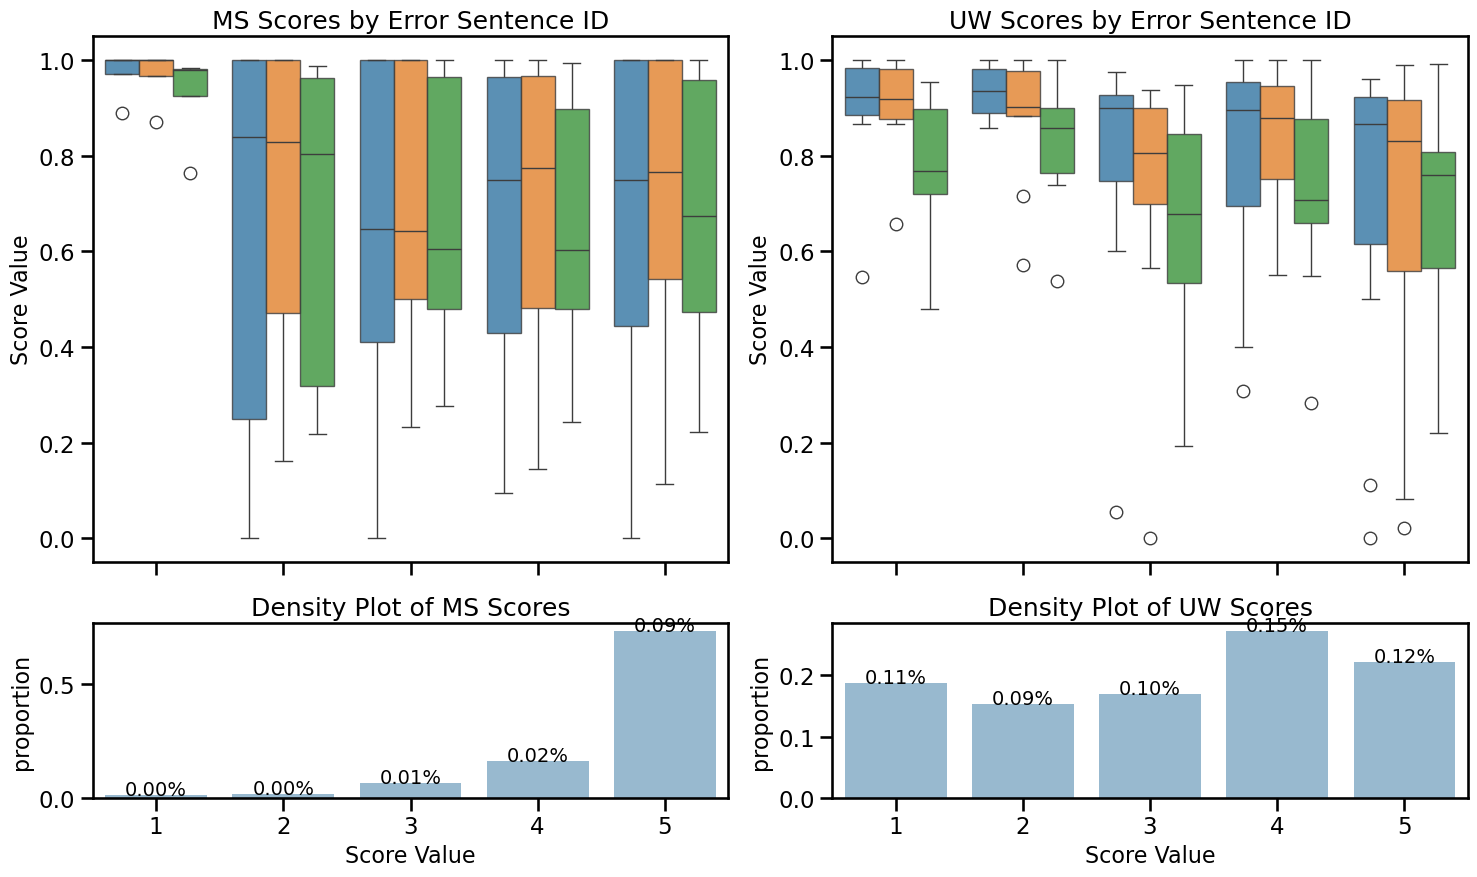

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine MS data into a DataFrame
ms_data = pd.DataFrame({
    'Score Value': ms_rouge1f_scores + ms_bertscores + ms_bleurtscores,
    'Score Type': ['Rouge1f'] * len(ms_rouge1f_scores) + ['BERTScores'] * len(ms_bertscores) + ['BLEURT'] * len(ms_bleurtscores),
    'Sentence Position': ms_bucketised_sent_ids + ms_bucketised_sent_ids + ms_bucketised_sent_ids,
    'Sentence Position (20%)': ms_fifth_bucketised_sent_ids + ms_fifth_bucketised_sent_ids + ms_fifth_bucketised_sent_ids
})

# Combine UW data into a DataFrame
uw_data = pd.DataFrame({
    'Score Value': uw_rouge1f_scores + uw_bertscores + uw_bleurtscores,
    'Score Type': ['Rouge1f'] * len(uw_rouge1f_scores) + ['BERTScores'] * len(uw_bertscores) + ['BLEURT'] * len(uw_bleurtscores),
    'Sentence Position': uw_bucketised_sent_ids + uw_bucketised_sent_ids + uw_bucketised_sent_ids,
    'Sentence Position (20%)': uw_fifth_bucketised_sent_ids + uw_fifth_bucketised_sent_ids + uw_fifth_bucketised_sent_ids
})

# Define the order of the x-axis categories and hue order
order = ["1", "2", "3", "4", "5"]
hue_order = ['Rouge1f', 'BERTScores', 'BLEURT']
custom_palette = {'Rouge1f': '#4BA1BF', 'BERTScores': '#bf4ba1', 'BLEURT': '#a1bf4b'}

plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'legend.fontsize': 14})
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex='col', gridspec_kw={'height_ratios': [3, 1]})
ax = axes.flatten()

# Plot combined boxplot for MS
# MS boxplot
sns.boxplot(x='Sentence Position (20%)', y='Score Value', hue='Score Type', data=ms_data, ax=ax[0], order=order, hue_order=hue_order, boxprops=dict(alpha=.8))
ax[0].set_title("MS Scores by Error Sentence ID")
ax[0].get_legend().remove()

# MS density plot
sns.countplot(ms_data, x="Sentence Position (20%)", stat="proportion", ax=ax[2], fill=True, alpha=0.5)
total = float(len(ms_data))  # Total number of observations for calculating proportions
for p in ax[2].patches:
    height = p.get_height()  # Get the height of each bar
    ax[2].text(p.get_x()+p.get_width()/2., height, '{:1.2f}%'.format(100 * height/total), ha="center") 
ax[2].set_xlabel('Score Value')
ax[2].set_title('Density Plot of MS Scores')

# UW boxplot
sns.boxplot(x='Sentence Position (20%)', y='Score Value', hue='Score Type', data=uw_data, ax=ax[1], order=order, hue_order=hue_order, boxprops=dict(alpha=.8))
ax[1].set_title("UW Scores by Error Sentence ID")
ax[1].get_legend().remove()

# UW density plot
sns.countplot(uw_data, x="Sentence Position (20%)", stat="proportion", ax=ax[3], fill=True, alpha=0.5)
total = float(len(uw_data))  # Total number of observations for UW data
for p in ax[3].patches:
    height = p.get_height()  # Get the height of each bar for UW data
    ax[3].text(p.get_x()+p.get_width()/2., height, '{:1.2f}%'.format(100 * height/total), ha="center")

ax[3].set_xlabel('Score Value')
ax[3].set_title('Density Plot of UW Scores')

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout(rect=[0, 0.1, 1, 1])

# Save the figure with a higher DPI
plt.savefig('scores_by_sent_id.pdf', format='pdf', dpi=300)

plt.show()

In [33]:
from scipy.stats import shapiro, kruskal

def shapiro_test(data):
    return shapiro(data)

def compute_kruskal(scores, bucketised_sent_ids):
    # Separate the scores into groups
    beginning_scores = [score for score, bucket in zip(scores, bucketised_sent_ids) if bucket == "beginning"]
    middle_scores = [score for score, bucket in zip(scores, bucketised_sent_ids) if bucket == "middle"]
    end_scores = [score for score, bucket in zip(scores, bucketised_sent_ids) if bucket == "end"]

    shapiro_stats = shapiro_test(beginning_scores)
    print(f"Beginning Score Shapiro-Wilk Test: Statistic={shapiro_stats[0]}, p-value={shapiro_stats[1]}")
    shapiro_stats = shapiro_test(middle_scores)
    print(f"Middle Score Shapiro-Wilk Test: Statistic={shapiro_stats[0]}, p-value={shapiro_stats[1]}")
    shapiro_stats = shapiro_test(end_scores)
    print(f"End Score Shapiro-Wilk Test: Statistic={shapiro_stats[0]}, p-value={shapiro_stats[1]}")

    # Perform one-way ANOVA
    return kruskal(beginning_scores, middle_scores, end_scores)

In [34]:
stat, p_value = compute_anova(ms_rouge1f_scores, ms_bucketised_sent_ids)
print(f"ROUGE 1 - Kruskal-Wallis H-Test statistic: {stat}, P-value: {p_value}")

Beginning Score Shapiro-Wilk Test: Statistic=0.7500000596046448, p-value=-6.830188112871838e-07
Middle Score Shapiro-Wilk Test: Statistic=0.8990678787231445, p-value=5.670784730682499e-07
End Score Shapiro-Wilk Test: Statistic=0.8650850653648376, p-value=1.7763839010864757e-10
ROUGE 1 - Kruskal-Wallis H-Test statistic: 6.074863334625852, P-value: 0.047957903307047155


In [35]:
stat, p_value = compute_anova(ms_bertscores, ms_bucketised_sent_ids)
print(f"BERTScore - Kruskal-Wallis H-Test statistic: {stat}, P-value: {p_value}")

Beginning Score Shapiro-Wilk Test: Statistic=0.7500007152557373, p-value=6.830188112871838e-07
Middle Score Shapiro-Wilk Test: Statistic=0.9066355228424072, p-value=1.3449148354993667e-06
End Score Shapiro-Wilk Test: Statistic=0.8670706748962402, p-value=2.203686538804206e-10
BERTScore - Kruskal-Wallis H-Test statistic: 5.024945788852445, P-value: 0.08106751974639029


In [36]:
stat, p_value = compute_anova(ms_bleurtscores, ms_bucketised_sent_ids)
print(f"BLEURT Score - Kruskal-Wallis H-Test statistic: {stat}, P-value: {p_value}")

Beginning Score Shapiro-Wilk Test: Statistic=0.7575559020042419, p-value=0.01674784906208515
Middle Score Shapiro-Wilk Test: Statistic=0.9094660878181458, p-value=1.876588953564351e-06
End Score Shapiro-Wilk Test: Statistic=0.9027233719825745, p-value=1.596835730310886e-08
BLEURT Score - Kruskal-Wallis H-Test statistic: 7.284766211918239, P-value: 0.026189856335238


## Analyse the mistake

### Confusion matrix

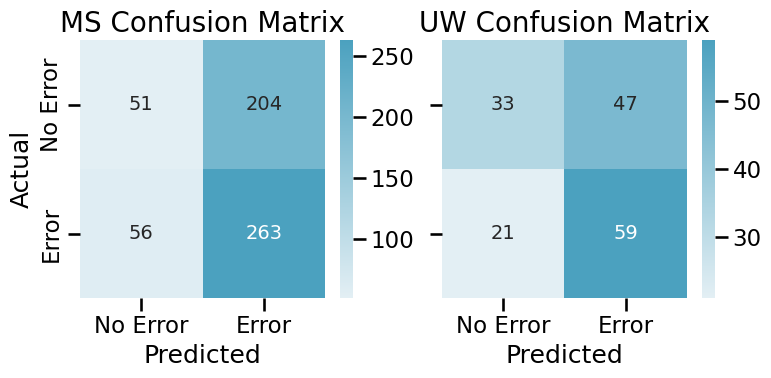

In [27]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

base_dir = "../predictions/"

ref_filepaths = {
    "ms": "../data/MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv",
    "uw": "../data/MEDIQA-CORR-2024-UW-ValidationSet-1-Full_Feb.csv"
}

predictions_dir = "cot_brief_8_shot__gpt_35_turbo__random__span_hinted"
# Setting up the figure for subplots
sns.set_context("talk")  # Sets the context to "talk", which is ideal for clear figures
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)  # Sharey to align the y-axis across subplots
# Your color
color_hex = "#4BA1BF"

# Create a colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#e3eff4", color_hex], N=256)
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16})

splits = ["ms", "uw"]
for i, split in enumerate(splits):
    # Load data
    df = pd.read_csv(
        os.path.join(base_dir, predictions_dir, f"{split}_prediction.csv")
    ).sort_values("id")
    ref_df = pd.read_csv(ref_filepaths[split]).sort_values("Text ID")

    # Ensure matching order of IDs
    assert df["id"].tolist() == ref_df["Text ID"].tolist()

    # Create confusion matrix
    conf_mat = confusion_matrix(ref_df['Error Flag'], df['predicted_error_flag'])

    # Plot the confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=cmap, ax=axes[i],
                xticklabels=['No Error', 'Error'],
                yticklabels=['No Error', 'Error'])
    axes[i].set_ylabel('Actual' if i == 0 else '', fontsize=18)  # Only add y label to the first subplot
    axes[i].set_xlabel('Predicted', fontsize=18)
    axes[i].set_title(f'{split.upper()} Confusion Matrix', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust the layout and save as PDF
plt.tight_layout()
plt.savefig('confusion_matrix.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [43]:
incorrects = []
for i, split in enumerate(splits):
    print(split)
    # Load data
    df = pd.read_csv(
        os.path.join(base_dir, predictions_dir, f"{split}_prediction.csv")
    ).sort_values("id").fillna("NA")
    ref_df = pd.read_csv(ref_filepaths[split]).sort_values("Text ID").fillna("NA")

    # Loop through both dfs and compare the predicted error flag with the actual error flag
    total = 0
    for _, (idx, pred, actual) in pd.concat([df['id'], df['predicted_corrected_sentence'], ref_df['Corrected Sentence']], axis=1).iterrows():
        if pred == "NA" or actual == "NA":
            continue
        try:
            if pred.lower() != actual.lower():
                incorrects += [idx]
        except Exception as e:
            print(pred)
            print(actual)
            raise e

ms
uw


In [46]:
incorrects

['ms-val-0',
 'ms-val-10',
 'ms-val-104',
 'ms-val-105',
 'ms-val-107',
 'ms-val-108',
 'ms-val-109',
 'ms-val-110',
 'ms-val-111',
 'ms-val-114',
 'ms-val-116',
 'ms-val-118',
 'ms-val-119',
 'ms-val-123',
 'ms-val-125',
 'ms-val-128',
 'ms-val-13',
 'ms-val-138',
 'ms-val-139',
 'ms-val-14',
 'ms-val-140',
 'ms-val-144',
 'ms-val-145',
 'ms-val-148',
 'ms-val-149',
 'ms-val-150',
 'ms-val-152',
 'ms-val-155',
 'ms-val-156',
 'ms-val-158',
 'ms-val-160',
 'ms-val-161',
 'ms-val-163',
 'ms-val-171',
 'ms-val-174',
 'ms-val-175',
 'ms-val-176',
 'ms-val-177',
 'ms-val-179',
 'ms-val-180',
 'ms-val-182',
 'ms-val-184',
 'ms-val-186',
 'ms-val-188',
 'ms-val-190',
 'ms-val-192',
 'ms-val-193',
 'ms-val-194',
 'ms-val-197',
 'ms-val-200',
 'ms-val-202',
 'ms-val-204',
 'ms-val-206',
 'ms-val-207',
 'ms-val-209',
 'ms-val-21',
 'ms-val-210',
 'ms-val-215',
 'ms-val-219',
 'ms-val-221',
 'ms-val-222',
 'ms-val-223',
 'ms-val-224',
 'ms-val-227',
 'ms-val-229',
 'ms-val-230',
 'ms-val-231',
 

## Hallucination in the reasoning?

In [36]:
from bs4 import BeautifulSoup

with open("../fava_predictions/fava__cot_brief_8_shot__gpt_35_turbo__random__span_hinted.json") as f:
    all_fava_predictions = json.load(f)

df = pd.DataFrame(columns=["text id", "split", "error_type", "reference_correction", "fava_prediction", "entity_hallucination", "fava_mark_correction", "fava_deletion"])
splits = ["ms", "uw"]
for i, split in enumerate(splits):
    reference_csv_file = ref_filepaths[split]

    reference_corrections, reference_flags, reference_sent_id = parse_reference_file(
        reference_csv_file
    )

    fava_predictions = all_fava_predictions[split]
    for idx, fava_prediction in fava_predictions.items():
        fava_prediction = fava_prediction.replace("<entity><mark></mark><delete></delete></entity>", "").strip()  # Remove entities without fix

        reference_correction = reference_corrections[idx]
        
        soup = BeautifulSoup(fava_prediction, 'html.parser')

        # Find all 'entity' tags
        entities = soup.find_all('entity')
        entity_hallucination = 1 if len(entities) > 0 else 0

        marked_texts = []
        deleted_texts = []

        for entity in entities:
            # Extract text from 'mark' and 'delete' tags within each 'entity'
            mark = entity.find('mark')
            delete = entity.find('delete')
            
            if mark:
                marked_texts.append(mark.text)
            if delete:
                deleted_texts.append(delete.text)
            
        # Add to df
        new_row_df = pd.DataFrame([{
            "text id": idx,
            "split": split,
            "error_type": "spurious" if reference_correction == "NA" else "inaccurate",
            "reference_correction": reference_correction,
            "fava_prediction": fava_prediction,
            "entity_hallucination": entity_hallucination,
            "fava_mark_correction": marked_texts,
            "fava_deletion": deleted_texts
        }])

        df = pd.concat([df, new_row_df], ignore_index=True)

In [37]:
df.to_csv("fava_predictions.csv", index=False)

## ClinicalBERTScore